In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Load the datasets
original_sales_data = pd.read_csv('../data/snp_dld_2024_transactions.csv', low_memory=False)
original_rentals_data = pd.read_csv('../data/snp_dld_2024_rents.csv', low_memory=False)

In [22]:
columns_to_drop_sales = [
    'transaction_number',  # ID column
    'entry_id',            # Metadata
    'meta_ts',             # Metadata timestamp
    'master_project_en',   # Very few non-null values
    'master_project_ar',   # Very few non-null values
    'property_type_ar',    # Duplicate of property_type_en
    'property_subtype_ar', # Duplicate of property_subtype_en
    'rooms_ar',            # Duplicate of rooms_en
    'project_name_ar',     # Duplicate of project_name_en
    'area_ar',             # Duplicate of area_en
    'nearest_landmark_ar', # Duplicate of nearest_landmark_en
    'nearest_metro_ar',    # Duplicate of nearest_metro_en
    'nearest_mall_ar',      # Duplicate of nearest_mall_en
    'parcel_id',  # not needed
    'transaction_type_en', #Duplicate of transaction_type_id
    'transaction_subtype_en', #Constant
    'transaction_subtype_id', #Constant
    'property_id', #Constant
    'property_type_id', #Constant
    'property_subtype_id', #Constant
    'building_age', #Constant
    'area_id', #Constant
    'is_freehold_text', #duplicate of is_freehold
    'property_usage_en', # Duplicate of property_usage_id
    'transaction_datetime_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day',  #Constant after handling dates
    'req_to_year', #Constant after handling dates
    'parking', # Replaced with parking count
    'nearest_metro_en', # percentage of missing data > 40%
    'nearest_mall_en'  # percentage of missing data > 40%
]

# List of columns to drop from rentals_data
columns_to_drop_rentals = [
    'ejari_contract_number', # ID column
    'land_property_id',      # Redundant ID column
    'entry_id',              # Metadata
    'meta_ts',               # Metadata timestamp
    'master_project_en',     # Very few non-null values
    'master_project_ar',     # Very few non-null values
    'property_type_ar',      # Duplicate of property_type_en
    'property_subtype_ar',   # Duplicate of property_subtype_en
    'property_usage_ar',     # Duplicate of property_usage_en
    'project_name_ar',       # Duplicate of project_name_en
    'area_ar',               # Duplicate of area_en
    'nearest_landmark_ar',   # Duplicate of nearest_landmark_en
    'nearest_metro_ar',      # Duplicate of nearest_metro_en
    'nearest_mall_ar',        # Duplicate of nearest_mall_en
    'property_id',   #constant
    'property_usage_id', #constant
    'area_id',   #constant
    'ejari_property_type_id',   #constant
    'ejari_property_sub_type_id',  #constant
    'parking', #97% missing data
    'parcel_id', # negative correlation
    'registration_date_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day',  #Constant after handling dates
    'req_to_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day', #Constant after handling dates
    'req_to_year',  #Constant after handling dates
    'registration_date_year',  #Constant after handling dates
    'req_from_year',  #Constant after handling dates
    'req_from_day',  #Constant after handling dates
    'req_to_year', #Constant after handling dates
    'is_freehold_text', # duplicate of is_freehold
    'rooms', # missing date more than 40%
    'project_name_en' # missing date more than 40%
]

In [23]:
def process_date_columns(df, date_columns):
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f"{col}_year"] = df[col].dt.year
            df[f"{col}_month"] = df[col].dt.month
            df[f"{col}_day"] = df[col].dt.day
            df[f"{col}_weekday"] = df[col].dt.weekday
            df[f"{col}_dayofyear"] = df[col].dt.dayofyear
    df.drop(columns=date_columns, inplace=True, errors='ignore')
    return df

sales_date_columns = ['transaction_datetime', 'req_from', 'req_to']
rentals_date_columns = ['registration_date', 'contract_start_date', 'contract_end_date', 'req_from', 'req_to']
sales_data = process_date_columns(original_sales_data, sales_date_columns)
rentals_data = process_date_columns(original_rentals_data, rentals_date_columns)

In [24]:
import re
import pandas as pd

def calculate_parking_count(value):
    """
    Calculate the parking count based on the given strategy:
    - Fields separated by commas are counted as separate spots unless 'to' is present.
    - If 'to' is present, calculate the range of parking spots.
    - Single identifiers like 'G-127' are counted as one spot.
    """
    if pd.isna(value):
        return 0  # No information

    total_count = 0
    fields = str(value).split(",")  # Split by commas
    for field in fields:
        field = field.strip()  # Remove extra whitespace
        if re.search(r"\bto\b", field, re.IGNORECASE):  # Check for 'to' (case insensitive)
            # Extract numbers in the range and calculate spots
            numbers = [int(num) for num in re.findall(r"\d+", field)]
            if len(numbers) == 2:  # Range is valid
                total_count += abs(numbers[1] - numbers[0]) + 1
        elif re.search(r"\d+", field):  # Single numeric identifier (e.g., G-127)
            total_count += 1
        else:
            total_count += 0  # Invalid or non-informative field
    return total_count

# Apply the logic to the `parking` column
sales_data['parking_count'] = sales_data['parking'].apply(calculate_parking_count)

# Save results for validation
sales_data[['parking', 'parking_count']].to_csv("processed_parking_count.csv", index=False)

# Example check
print(sales_data[['parking', 'parking_count']].tail())

       parking  parking_count
162801  B2-081              1
162802     NaN              0
162803  B2-140              1
162804   G-114              1
162805   G-127              1


In [25]:
sales_data.drop(columns=columns_to_drop_sales, inplace=True)
rentals_data.drop(columns=columns_to_drop_rentals, inplace=True)

In [26]:

# Display the number and percentage of missing values for Sales Data
print("Missing Values in Sales Data:")
missing_sales = sales_data.isnull().sum().to_frame(name="Missing Count")
missing_sales["Percentage"] = (missing_sales["Missing Count"] / len(sales_data)) * 100
print(missing_sales[missing_sales["Missing Count"] > 0])

# Display the number and percentage of missing values for Rentals Data
print("\nMissing Values in Rentals Data:")
missing_rentals = rentals_data.isnull().sum().to_frame(name="Missing Count")
missing_rentals["Percentage"] = (missing_rentals["Missing Count"] / len(rentals_data)) * 100
print(missing_rentals[missing_rentals["Missing Count"] > 0])

Missing Values in Sales Data:
                      Missing Count  Percentage
transaction_size_sqm            660    0.405390
is_freehold                     684    0.420132
property_subtype_en            1392    0.855005
rooms_en                      23257   14.285100
project_name_en               24760   15.208285
nearest_landmark_en           47412   29.121777

Missing Values in Rentals Data:
                     Missing Count  Percentage
annual_amount                   14    0.001873
property_subtype_en           2545    0.340510
property_usage_en             2844    0.380515
nearest_landmark_en          56810    7.600935
nearest_metro_en            110681   14.808645
nearest_mall_en             120826   16.166003


## Handling small percentage of missing values

In [27]:
small_missing_sales = ['transaction_size_sqm', 'is_freehold', 'property_subtype_en'] 
sales_data[small_missing_sales].head()

,transaction_size_sqm,is_freehold,property_subtype_en
0,66.47,t,Flat
1,70.76,t,Flat
2,115.33,f,Flat
3,110.02,t,Flat
4,73.32,t,Flat


In [28]:
sales_data['is_freehold'].unique()

array(['t', 'f', nan], dtype=object)

## Impute values for small missing values. 

In [29]:
# Fill missing values for `is_freehold` with the mode
sales_data['is_freehold'] = sales_data['is_freehold'].fillna(sales_data['is_freehold'].mode()[0])

# Encode `is_freehold` into binary values
sales_data['is_freehold_encoded'] = sales_data['is_freehold'].map({'t': 1, 'f': 0})



# Verify the results
print("Unique values in 'is_freehold_encoded':")
print(sales_data['is_freehold_encoded'].unique())


Unique values in 'is_freehold_encoded':
[1 0]


In [30]:
# Impute missing values in `transaction_size_sqm` with the median
median_value = sales_data['transaction_size_sqm'].median()
sales_data['transaction_size_sqm'] = sales_data['transaction_size_sqm'].fillna(median_value)

# Verify
print("Missing values in 'transaction_size_sqm':", sales_data['transaction_size_sqm'].isnull().sum())


Missing values in 'transaction_size_sqm': 0


In [31]:
# Impute missing values in `property_subtype_en` with the mode
mode_value = sales_data['property_subtype_en'].mode()[0]
sales_data['property_subtype_en'] = sales_data['property_subtype_en'].fillna(mode_value)

# Verify
print("Missing values in 'property_subtype_en':", sales_data['property_subtype_en'].isnull().sum())


Missing values in 'property_subtype_en': 0


In [32]:
mean_value = rentals_data['annual_amount'].mean()
rentals_data['annual_amount'] = rentals_data['annual_amount'].fillna(mean_value)

# Verify
print("Missing values in 'annual_amount':", rentals_data['annual_amount'].isnull().sum())


Missing values in 'annual_amount': 0


In [33]:
# Impute missing values with the mode
mode_value = rentals_data['property_subtype_en'].mode()[0]
rentals_data['property_subtype_en'] = rentals_data['property_subtype_en'].fillna(mode_value)


In [34]:
print(rentals_data['property_usage_en'].unique())
print("Missing values in 'property_usage_en':", rentals_data['property_usage_en'].isnull().sum())


['Residential' 'Commercial' 'Industrial' nan 'Storage'
 'Industrial / Commercial' 'Tourist origin' 'Educational facility'
 'Health Facility' 'Agriculture']
Missing values in 'property_usage_en': 2844


In [35]:
# Impute missing values with the mode
most_frequent_usage = rentals_data['property_usage_en'].mode()[0]
rentals_data['property_usage_en'].fillna(most_frequent_usage, inplace=True)

# Verify no missing values remain
print(rentals_data['property_usage_en'].isnull().sum())


0


/tmp/ipykernel_29804/3468003011.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rentals_data['property_usage_en'].fillna(most_frequent_usage, inplace=True)


## Handle columns with medium percentage missing values 9%-30%

In [36]:
sales_data['rooms_en'].unique()

array(['1 B/R', '2 B/R', '3 B/R', 'Studio', nan, '4 B/R', '5 B/R',
       '6 B/R', 'Office', 'PENTHOUSE', 'Shop', '7 B/R', 'Single Room',
       'Hotel'], dtype=object)

In [37]:
sales_data['rooms_en'].isnull().sum()

23257

In [39]:
# Define refined mapping for room counts
room_mapping = {
    'Studio': 0,
    'Single Room': 1,
    '1 B/R': 1,
    '2 B/R': 2,
    '3 B/R': 3,
    '4 B/R': 4,
    '5 B/R': 5,
    '6 B/R': 6,
    '7 B/R': 7,
    'PENTHOUSE': 8,  # Assign an arbitrary high value
    'Office': -1,    # Placeholder for office
    'Shop': -1,      # Placeholder for shop
    'Hotel': 10,     # Assign 10 rooms for hotel
}

# Create a numeric column for room counts
sales_data['rooms_numeric'] = sales_data['rooms_en'].map(room_mapping)


In [41]:
# For non-residential types
non_residential_mean_sizes = sales_data.groupby('rooms_en')['property_size_sqm'].mean()
print("Average Size for Non-Residential Types:")
print(non_residential_mean_sizes[['Hotel', 'Office', 'Shop']])

# Assign representative values based on size ranges
sales_data.loc[sales_data['rooms_en'] == 'Office', 'rooms_numeric'] = 5  # Example value based on avg size
sales_data.loc[sales_data['rooms_en'] == 'Shop', 'rooms_numeric'] = 2    # Example value based on avg size


Average Size for Non-Residential Types:
rooms_en
Hotel     31554.800000
Office      131.346197
Shop        172.384767
Name: property_size_sqm, dtype: float64


In [42]:
# Compute correlation
correlation = sales_data[['rooms_numeric', 'property_size_sqm']].corr()
print("Correlation between rooms_numeric and property_size_sqm:")
print(correlation)


Correlation between rooms_numeric and property_size_sqm:
                   rooms_numeric  property_size_sqm
rooms_numeric           1.000000           0.511559
property_size_sqm       0.511559           1.000000


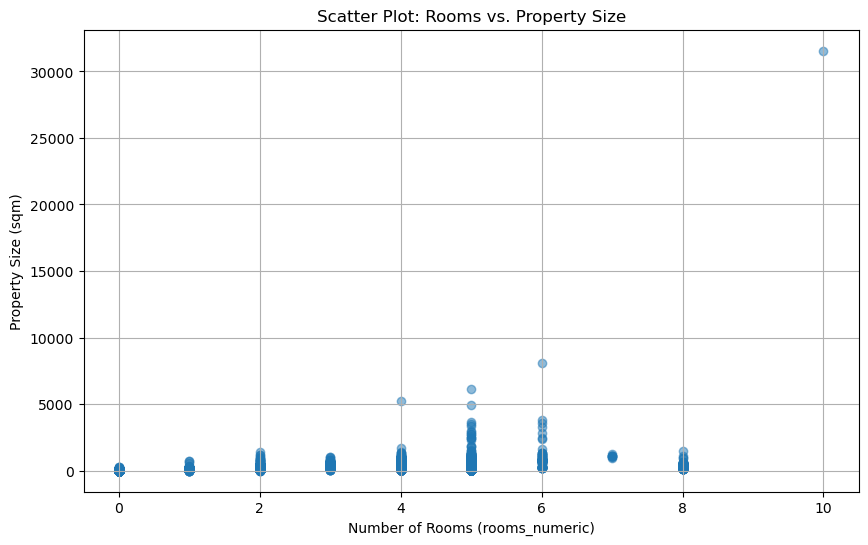

In [43]:
import matplotlib.pyplot as plt

# Scatter plot to visualize correlation
plt.figure(figsize=(10, 6))
plt.scatter(sales_data['rooms_numeric'], sales_data['property_size_sqm'], alpha=0.5)
plt.title("Scatter Plot: Rooms vs. Property Size")
plt.xlabel("Number of Rooms (rooms_numeric)")
plt.ylabel("Property Size (sqm)")
plt.grid()
plt.show()


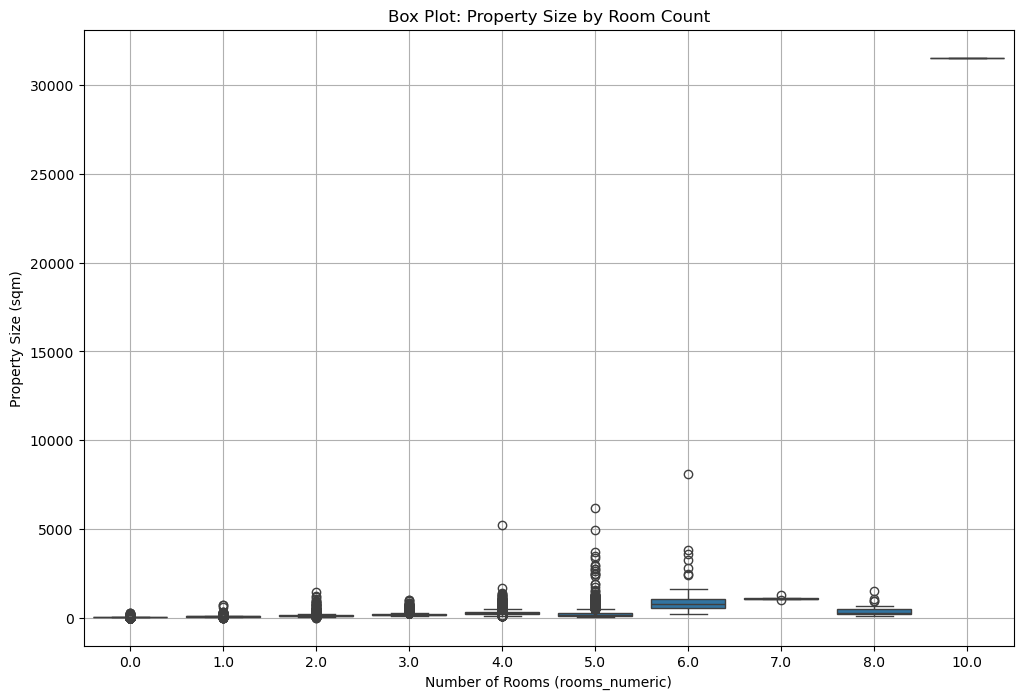

In [44]:
# Box plot to visualize the distribution of property sizes by room count
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(data=sales_data, x='rooms_numeric', y='property_size_sqm')
plt.title("Box Plot: Property Size by Room Count")
plt.xlabel("Number of Rooms (rooms_numeric)")
plt.ylabel("Property Size (sqm)")
plt.grid()
plt.show()


In [45]:
# Split data into known and unknown room counts
known_rooms = sales_data[sales_data['rooms_numeric'].notnull()]
unknown_rooms = sales_data[sales_data['rooms_numeric'].isnull()]


In [46]:
from sklearn.linear_model import LinearRegression

# Features and target
X_train = known_rooms[['property_size_sqm']]
y_train = known_rooms['rooms_numeric']

# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression()

In [47]:
# Predict missing room counts
X_missing = unknown_rooms[['property_size_sqm']]
predicted_rooms = regressor.predict(X_missing)

# Assign predictions to the missing rows (round to nearest integer if needed)
sales_data.loc[sales_data['rooms_numeric'].isnull(), 'rooms_numeric'] = predicted_rooms.round()


In [48]:
print("Updated Room Counts:")
print(sales_data['rooms_numeric'].value_counts())


Updated Room Counts:
rooms_numeric
1.0      53076
2.0      42081
0.0      25262
3.0      20215
4.0      10548
         ...  
51.0         1
219.0        1
185.0        1
235.0        1
317.0        1
Name: count, Length: 221, dtype: int64


In [49]:
sales_data['rooms_numeric'].unique()

array([1.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 4.0000e+00,
       5.0000e+00, 7.0000e+00, 6.0000e+00, 1.5000e+01, 1.4000e+01,
       3.6000e+01, 8.0000e+00, 1.6000e+01, 1.3000e+01, 1.8000e+01,
       9.0000e+00, 1.0000e+01, 1.1000e+01, 1.2000e+01, 1.7000e+01,
       2.2000e+01, 3.0000e+01, 3.8000e+01, 1.9000e+01, 4.2000e+01,
       2.1000e+01, 1.1000e+02, 2.0000e+01, 1.1800e+02, 1.9700e+02,
       8.8000e+01, 3.3000e+01, 2.9910e+03, 3.2000e+02, 1.3300e+02,
       9.6406e+04, 1.3600e+02, 2.6000e+01, 2.5000e+01, 9.1000e+01,
       3.7000e+01, 5.4000e+01, 2.8300e+02, 1.0900e+02, 5.7000e+01,
       8.9000e+01, 4.9000e+01, 5.2000e+01, 3.2000e+01, 2.8000e+01,
       1.6600e+02, 2.4000e+01, 5.9000e+01, 4.6000e+01, 3.9000e+01,
       5.0000e+01, 7.2000e+01, 2.3000e+01, 2.2600e+02, 2.7000e+01,
       6.3000e+01, 5.1400e+02, 4.7000e+01, 4.1000e+01, 4.3000e+01,
       2.5700e+02, 7.1000e+01, 7.5000e+01, 6.2000e+01, 1.3100e+02,
       2.9000e+01, 1.7970e+03, 2.6290e+03, 9.0000e+01, 7.0000e

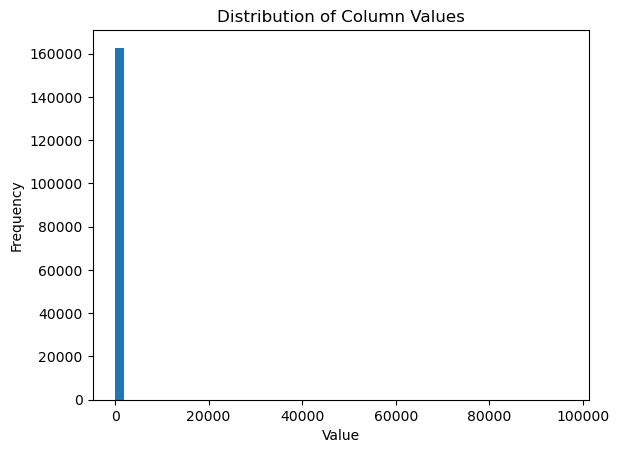

In [51]:
import matplotlib.pyplot as plt

plt.hist(sales_data['rooms_numeric'], bins=50)
plt.title("Distribution of Column Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Select relevant features for imputation
features = ['property_size_sqm', 'amount', 'transaction_size_sqm']
target = 'rooms_en'

# Prepare data
data_with_rooms = sales_data.dropna(subset=[target])  # Rows with known rooms_en
data_missing_rooms = sales_data[sales_data[target].isnull()]  # Rows with missing rooms_en

# Encode rooms_en as numeric for the model
label_encoder = LabelEncoder()
data_with_rooms['rooms_en_encoded'] = label_encoder.fit_transform(data_with_rooms[target])

# Standardize the features for KNN
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_with_rooms[features])

# Train KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
data_with_rooms['rooms_en_encoded'] = knn_imputer.fit_transform(data_with_rooms[['rooms_en_encoded'] + features])[:, 0]

# Predict missing values
missing_scaled_features = scaler.transform(data_missing_rooms[features])
missing_predicted_rooms = knn_imputer.transform(missing_scaled_features)[:, 0]

# Decode the predictions back to original categories
data_missing_rooms[target] = label_encoder.inverse_transform(missing_predicted_rooms.astype(int))

# Combine the datasets back
sales_data_imputed = pd.concat([data_with_rooms, data_missing_rooms], axis=0)

# Verify imputation
print("Missing values in 'rooms_en' after imputation:", sales_data_imputed['rooms_en'].isnull().sum())


In [52]:
# Updated Mapping
rooms_mapping = {
    'Studio': 1,
    '1 B/R': 1,
    '2 B/R': 2,
    '3 B/R': 3,
    '4 B/R': 4,
    '5 B/R': 5,
    '6 B/R': 6,
    '7 B/R': 7,
    'Single Room': 1,
    'PENTHOUSE': 5,
    'Office': 1.5,  # Representative value for offices
    'Shop': 1,      # Assume one shop counts as one unit
    'Hotel': 10     # Assume hotels have an average of 10 rooms
}

# Create the new column with updated mapping
sales_data['rooms_en_imputed'] = sales_data['rooms_en'].map(rooms_mapping)

# Verify the results
print(sales_data['rooms_en_imputed'].unique())


[ 1.   2.   3.   nan  4.   5.   6.   1.5  7.  10. ]


In [54]:
from sklearn.impute import KNNImputer

# Combine the room column with related numerical features for imputation
knn_features = ['rooms_en_imputed', 'property_size_sqm']

# Filter only the rows that have the necessary numerical data
knn_data = sales_data[knn_features]

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Perform KNN Imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Update the imputed values back into the DataFrame
sales_data['rooms_en_imputed'] = knn_data_imputed[:, 0]  # First column corresponds to rooms_en_imputed




Missing values in 'rooms_en_imputed': 0


NameError: name 'np' is not defined

Missing values in 'rooms_en_imputed': 0
Unique values in 'rooms_en_imputed': [ 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7
  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.2
  5.4  5.6  5.8  6.   7.  10. ]


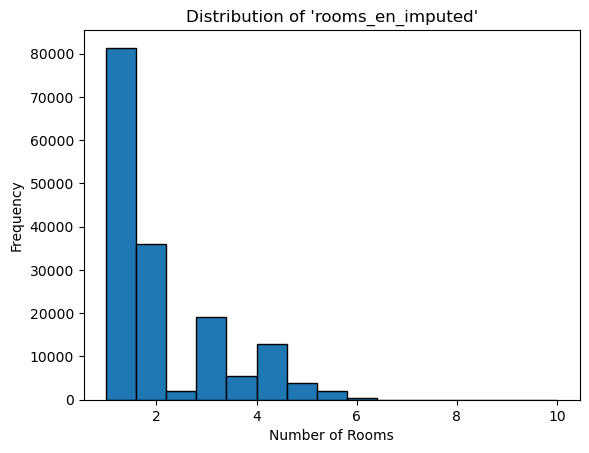

In [55]:
import numpy as np
# Step 4: Check for Missing Values
print("Missing values in 'rooms_en_imputed':", sales_data['rooms_en_imputed'].isnull().sum())
print("Unique values in 'rooms_en_imputed':", np.unique(sales_data['rooms_en_imputed']))

# Step 5: Visualize the Imputed Data
plt.hist(sales_data['rooms_en_imputed'], bins=15, edgecolor='black')
plt.title("Distribution of 'rooms_en_imputed'")
plt.xlabel("Number of Rooms")
plt.ylabel("Frequency")
plt.show()

## Handle project_name_en Is it worth keeping?

In [56]:
sales_data['project_name_en'].unique()

array(['THE VYBE', 'Elitz 3 By Danube ', 'TRIA BY DEYAAR', ...,
       'The Oasis - Palmiera 3', 'azizi veince 12', 'LA VISTA 05'],
      dtype=object)

In [57]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Filter rows with non-missing project_name_en
non_missing_projects = sales_data[sales_data['project_name_en'].notnull()]

# Step 2: Encode project_name_en to numerical values
label_encoder = LabelEncoder()
non_missing_projects['project_name_en_encoded'] = label_encoder.fit_transform(non_missing_projects['project_name_en'])

# Step 3: Compute correlation between project_name_en_encoded and amount
correlation = non_missing_projects[['project_name_en_encoded', 'amount']].corr()

# Display the correlation
print("Correlation between `project_name_en` and `amount`:")
print(correlation)


Correlation between `project_name_en` and `amount`:
                         project_name_en_encoded    amount
project_name_en_encoded                 1.000000  0.020358
amount                                  0.020358  1.000000


/tmp/ipykernel_29804/3939853182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_missing_projects['project_name_en_encoded'] = label_encoder.fit_transform(non_missing_projects['project_name_en'])


In [58]:
from sklearn.preprocessing import OrdinalEncoder

sales_data['project_name_en_encoded'] = OrdinalEncoder().fit_transform(
    sales_data[['project_name_en']].fillna('Unknown')
)
target_mean = sales_data.groupby('project_name_en')['amount'].mean()
sales_data['project_name_en_encoded'] = sales_data['project_name_en'].map(target_mean)


In [59]:
from sklearn.model_selection import train_test_split

X = sales_data[['project_name_en_encoded']]  # or include other features too
y = sales_data['amount']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


Mean Squared Error: 907860598265891.4
R2 Score: 0.01619019260059129


In [61]:
# Get feature importance
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort and display
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


                   Feature  Importance
0  project_name_en_encoded         1.0


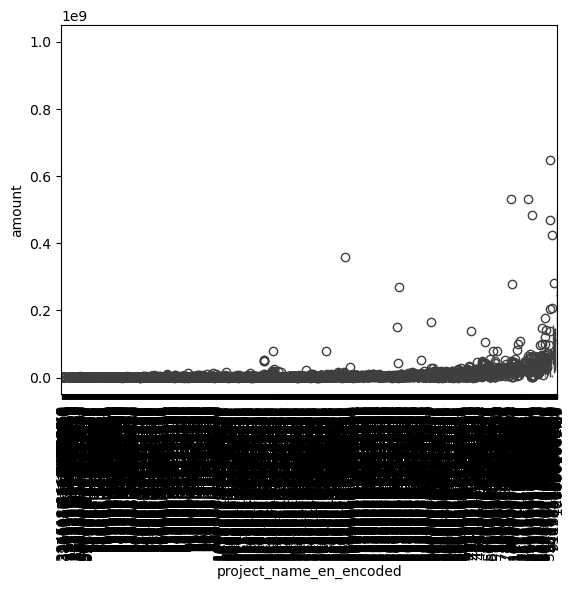

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=sales_data, x='project_name_en_encoded', y='amount')
plt.xticks(rotation=90)
plt.show()


The results indicate the following:

Mean Squared Error (MSE): A high MSE suggests the model isn't making accurate predictions, which could be due to project_name_en_encoded not having strong predictive power for amount.
R2 Score: An R² value of 0.016 suggests that the model explains only 1.6% of the variance in the target variable (amount), meaning the feature project_name_en_encoded alone is not very effective.
Feature Importance: Since the model is trained with just one feature (project_name_en_encoded), its importance is naturally 1.0. This doesn't mean it's predictive, just that it's the only feature being used
In this case, this feature could cause noise to the model. So I will drop it.

In [63]:
X = sales_data[['project_name_en_encoded', 'transaction_type_id', 'property_size_sqm']]  # Add relevant features
rf.fit(X_train, y_train)
print("R2 Score with additional features:", r2_score(y_test, rf.predict(X_test)))


R2 Score with additional features: 0.01619019260059129


In [64]:
# Basic statistics
print("Unique Values in 'nearest_landmark_en':", sales_data['nearest_landmark_en'].nunique())
print("Missing Values in 'nearest_landmark_en':", sales_data['nearest_landmark_en'].isnull().sum())


Unique Values in 'nearest_landmark_en': 14
Missing Values in 'nearest_landmark_en': 47412
